<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#--Read-data" data-toc-modified-id="--Read-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>- Read data</a></span></li><li><span><a href="#--Content-based" data-toc-modified-id="--Content-based-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>- Content based</a></span><ul class="toc-item"><li><span><a href="#--Préparation-des-données" data-toc-modified-id="--Préparation-des-données-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>- Préparation des données</a></span></li><li><span><a href="#--Construction-du-modèle" data-toc-modified-id="--Construction-du-modèle-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>- Construction du modèle</a></span></li><li><span><a href="#--Exemple-de-recommandations" data-toc-modified-id="--Exemple-de-recommandations-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>- Exemple de recommandations</a></span></li><li><span><a href="#--Estimation-des-performances" data-toc-modified-id="--Estimation-des-performances-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>- Estimation des performances</a></span></li></ul></li><li><span><a href="#--Collaborative-filtering" data-toc-modified-id="--Collaborative-filtering-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>- Collaborative filtering</a></span><ul class="toc-item"><li><span><a href="#--Création-/-entraînement-du-modèle" data-toc-modified-id="--Création-/-entraînement-du-modèle-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>- Création / entraînement du modèle</a></span></li><li><span><a href="#--Exemple-de-prédictions" data-toc-modified-id="--Exemple-de-prédictions-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>- Exemple de prédictions</a></span></li><li><span><a href="#--Evaluation-des-performances" data-toc-modified-id="--Evaluation-des-performances-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>- Evaluation des performances</a></span></li></ul></li><li><span><a href="#--Comparaison-des-performances" data-toc-modified-id="--Comparaison-des-performances-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>- Comparaison des performances</a></span></li></ul></div>

In [1]:
import numpy as np
import pandas as pd
import scipy
import scipy.sparse as sparse
from scipy.sparse import csr_matrix
import os
import pickle
import math
import random
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import implicit

random.seed(90)

# - Read data

In [2]:
INPUT_DIR = "../Input_data"

In [3]:
df_list = []
for dirname, _, filenames in os.walk(os.path.join(INPUT_DIR, "clicks")):
    for f in filenames:
        df = pd.read_csv(os.path.join(dirname, f), index_col=None, header=0)
        df_list.append(df)
df = pd.concat(df_list, axis=0, ignore_index=True)

In [4]:
df

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,183365,1508142981832860,1508142981000,2,206785,1508143245623,4,4,20,1,21,2
1,183365,1508142981832860,1508142981000,2,336254,1508143275623,4,4,20,1,21,2
2,245204,1508142988282861,1508142988000,2,236599,1508143968494,4,1,17,1,21,1
3,245204,1508142988282861,1508142988000,2,235038,1508143998494,4,1,17,1,21,1
4,217710,1508142988252862,1508142988000,3,331116,1508143213851,4,1,17,1,21,2
...,...,...,...,...,...,...,...,...,...,...,...,...
2988176,6090,1507610159379239,1507610159000,4,137162,1507610306862,4,3,20,1,13,2
2988177,6090,1507610159379239,1507610159000,4,129165,1507610410069,4,3,20,1,13,1
2988178,6090,1507610159379239,1507610159000,4,31352,1507610440069,4,3,20,1,13,1
2988179,256254,1507610174243240,1507610174000,2,271261,1507612723823,4,1,17,1,21,2


In [5]:
items_df = pd.read_csv(os.path.join(INPUT_DIR, "articles_metadata.csv"), index_col=None, header=0)
items_df.head()

,article_id,category_id,created_at_ts,publisher_id,words_count
0,0,0,1513144419000,0,168
1,1,1,1405341936000,0,189
2,2,1,1408667706000,0,250
3,3,1,1408468313000,0,230
4,4,1,1407071171000,0,162


In [6]:
embedding_file = open(os.path.join(INPUT_DIR, "articles_embeddings.pickle"), "rb")
embedding = pickle.load(embedding_file)

In [7]:
embedding.shape

(364047, 250)

# - Content based

https://www.kaggle.com/gspmoreira/recommender-systems-in-python-101#Evaluation

## - Préparation des données

In [8]:
cb_df = df.copy()
cb_df.rename(columns={"user_id": "user", "click_article_id" : "item"}, inplace=True)
cb_df["click_count"] = 1

In [9]:
def smooth_user_preference(x):
    """
    Smooth click counts :
    Input :
        - x (int) : number of clicks on an article for a single user
    Output :
        - (float) : smoothed number of clicks
    """

    return math.log(1+x, 2)

interactions_full_df = cb_df.groupby(["user", "item"])["click_count"].sum() \
                .apply(smooth_user_preference).reset_index()

interactions_train_df, interactions_test_df = train_test_split(interactions_full_df,
                                                             stratify = interactions_full_df["user"],
                                                             test_size=0.2,
                                                             random_state=90)

print("train set size =", len(interactions_train_df))
print("test set size =", len(interactions_test_df))

# Indexing by user will speed up searches
interactions_full_indexed_df =interactions_full_df.set_index("user")
interactions_train_indexed_df = interactions_train_df.set_index("user")
interactions_test_indexed_df = interactions_test_df.set_index("user")

train set size = 2360568
test set size = 590142


## - Construction du modèle

In [10]:
class ContentBasedRecommender():
    """
    Recommend top n articles based on content based filtering.
    Calculate a mean user profile based on his reading history then find the most similar articles
    using cosine similarity
    """
       
    def __init__(self, data, items_df, embedding):
        """
        Input :
            - data (pd.Dataframe) : dataframe containing users / articles interactions
            - items_df (pd.Dataframe) : dataframe with all articles and their 
                                        their attached information
            - embedding (np.array) : embedding matrix
        """
        
        self.df = data.copy()
        self.items_df = items_df
        self.embedding = embedding
        
        self.item_ids = self.items_df["article_id"].unique().tolist()
        

        
    def inside_check(self):
        # Just used to return internal variables for debugging
        return self.df
              
    
    def get_single_item_profile(self, item_id):
        """
        Get single item embedding
        Input :
            - item_id (int) : article id
        Output :
            - item_profile (np.array) : embedding data for article id
        """
        
        idx = self.item_ids.index(item_id)
        item_profile = embedding[idx]

        return item_profile

    def get_mult_items_profiles(self, ids):
        """
        Aggregate multiple articles embedding vectors in a matrix
        Input :
            - ids (list of int) : list of article id's
        Output :
            - (np.array) : matrix of embedded articles
        """
        
        items_profiles_list = [self.get_single_item_profile(x) for x in ids]

        return np.array(items_profiles_list)

    def build_single_user_profile(self, user_id):
        """
        Calculate a user profile based on his reading history (weighed average of embedding
        vectors).
        Input :
            - user_id (int)
        Output :
            - user_items_clicks_count_weighed_av (np.array) : one-dimension array describing
            user profile
        """
        
        interactions_user_df = self.df.loc[user_id]
        user_items_profile = self.get_mult_items_profiles(interactions_user_df["item"])

        user_items_clicks_count = np.array(interactions_user_df["click_count"]).reshape(-1, 1)
        # Weighed average of item profiles by click count
        user_items_clicks_count_weighed_av = np.sum(np.multiply(user_items_profile, user_items_clicks_count),
                                                   axis=0) / np.sum(user_items_clicks_count)

        return user_items_clicks_count_weighed_av

    
    def _get_similar_items_to_user_profile(self, user_id, topn=10):
        """
        Calculate similar items for a single user using cosine similarity
        Input :
            - user_id (int)
        Output :
            - similar_items (list of tupples) : recommended items and similarity values
        """
            
        user_vector = self.build_single_user_profile(user_id)
        # Compute cosine similarity between user profile and all items profiles
        cosine_sim = cosine_similarity([user_vector], embedding)
        
        # Get the top similar items
        similar_indices = cosine_sim.argsort().flatten()[-topn:]
        similar_items = sorted([(self.item_ids[i], cosine_sim[0, i]) for i in similar_indices],
                              key=lambda x: -x[1])
        
        return similar_items
    
    def _get_items_interacted(self, user_id, interactions_df):
        """
        List articles that have already been read by a single user
        Input :
            - user_id (int)
            - interactions_df (pd.DataFrame) : dataframe containing the reading information
        Output :
            - interacted_items_set (list of int) : articles already read by the user.
        """
        
        interacted_items = interactions_df.loc[user_id]["item"]
        interacted_items_set = set(interacted_items if type(interacted_items) == pd.Series \
                                    else [interacted_items])

        return interacted_items_set
    
    def recommend_items(self, user_id, df, items_to_ignore=[], topn=10, verbose=False):
        """
        Format recommended articles
        Input :
            - user_id (int)
            - items_to_ignore (list of int) : articles that we don't want to include into
                                            the recommendation.
            - topn (int) : number of articles to return
            - verbose (bool) : add extra information to recommendations
        Output :
            - recommendations_df (pd.Dataframe): recommended items and additional information
        """
        
        interacted_items = self._get_items_interacted(user_id, df)
        #tempo = self.df.loc[user_id, "item"].values.tolist()
        items_to_ignore.extend(interacted_items)
        similar_items = self._get_similar_items_to_user_profile(user_id,
                                                                topn=topn+len(interacted_items))
        # Ignore items that user has already interacted
        similar_items_filtered = list(filter(lambda x: x[0] not in items_to_ignore, similar_items))
        
        recommendations_df = pd.DataFrame(similar_items_filtered,
                                          columns=["item", "similarity"]) \
                                .head(topn)
        
        if verbose :
            if self.items_df is None:
                raise Exception ("items_df' is required in verbose mode")
            recommendations_df = recommendations_df.merge(self.items_df, how="left",
                                                         left_on="item",
                                                         right_on="article_id")[["item",
                                                                                 "similarity",
                                                                                 "category_id",
                                                                                 "words_count"]] 
        return recommendations_df
    
    def evaluate_perfo(self, n_users, k):
        """
        Calculate precision@k and recall@k for a sample of users (recommendation calculation time
        is about 1.5 s / user so we need to calculate performances on a reduced number of users)
        Input :
            - n_users (int) : number of users used for performance evaluation
            - k (int) : number of predicted items
        Output :
            - list of metrics (float):
                - precision
                - recall
                -f1_score
        """
        
        user_indices = interactions_test_indexed_df.index.values.tolist()
        sample_users = random.sample(user_indices, n_users)
        
        precisions = []
        recalls = []
        for user_id in sample_users:
            try :
                actuals = interactions_train_indexed_df.loc[user_id, "item"].values
            except AttributeError:
                actuals = [ (int(interactions_train_indexed_df.loc[user_id, "item"])) ]
            predictions_df = self.recommend_items(user_id, interactions_test_indexed_df,topn=k)
            predictions = predictions_df["item"].values
            hits = len(set(actuals) & set(predictions))
            precision = hits / k
            recall = hits / len(actuals)
            precisions.append(precision)
            recalls.append(recall)
        precision = np.mean(precisions)
        recall = np.mean(recalls)
        try:
            f1 = (2 * precision * recall) / (precision + recall)
        except ZeroDivisionError:
            f1 = 0
        
        return [precision, recall, f1]

In [11]:
%%time
cb_model = ContentBasedRecommender(interactions_full_indexed_df, items_df, embedding)

CPU times: user 24.2 ms, sys: 16.1 ms, total: 40.3 ms
Wall time: 40.1 ms


## - Exemple de recommandations

In [12]:
def dispay_user_reading_infos(user_id):
    user_df = interactions_full_indexed_df.copy()
    user_df = user_df.loc[user_id]
    user_df = user_df.merge(items_df, how="left",
                            left_on="item",
                            right_on="article_id")[["item", "click_count",
                                                    "category_id", "words_count"]]
    
    return user_df

In [13]:
%%time
rec_items = cb_model.recommend_items(0, interactions_full_indexed_df, verbose=True)
rec_items


CPU times: user 1.12 s, sys: 699 ms, total: 1.82 s
Wall time: 530 ms


,item,similarity,category_id,words_count
0,162235,0.874799,281,222
1,160966,0.848911,281,226
2,162230,0.841757,281,235
3,155943,0.841703,281,229
4,160079,0.841227,281,188
5,107637,0.839794,228,217
6,153938,0.839409,281,203
7,152100,0.838458,281,241
8,153006,0.832049,281,270
9,156634,0.830433,281,160


In [14]:
user_0 = dispay_user_reading_infos(0)
user_0

,item,click_count,category_id,words_count
0,68866,1.0,136,226
1,87205,1.0,186,137
2,87224,1.0,186,100
3,96755,1.0,209,211
4,157541,1.0,281,280
5,160158,1.0,281,145
6,233470,1.0,375,292
7,313996,1.0,431,265


Les articles lus sont supprimés des recommandations donc comparer les 2 listes n'apporte pas d'information. On peut en revanche regarder si les catégories des articles recommandés correspondent aux habitudes de lecture de l'utilisateur.

On peu voir dans les tableaux ci-dessus que tous les articles recommandés appartiennent à la catégorie 281 alors que les articles lus sont répartis sur plusieurs d'entre elles.

La boucle ci-dessous permet d'automatiser le processus de comparaison.

In [15]:
check_cat = []
for cat in user_0["category_id"].values:
    check_cat.append(cat in rec_items["category_id"].values)

print(check_cat)

[False, False, False, False, True, True, False, False]


## - Estimation des performances

Le principe est de calculer le profil moyen d'un utilisateur dans la base de test, de prédire les articles intéressants et de les compararer aux articles effectivement lus de la base d'entraînement.

Pour chaque utilisateur, le calcul des recommandations prend environ 1.5 s. Pour limiter le temps de calcul, l'évaluation des performances est faite sur un nombre très réduit d'utilisateurs. Les valeurs retournées ne sont donc que des ordres de grandeur.

In [16]:
%%time
cb_perfos = cb_model.evaluate_perfo(n_users=100, k=10)
print("Pour 100 utilisateurs :")
print("\tPrecision@10 = {:.3f}".format(cb_perfos[0]))
print("\tRecall@10 = {:.3f}".format(cb_perfos[1]))
print("\tf1_score@10 = {:.3f}".format(cb_perfos[2]))

Pour 100 utilisateurs :
	Precision@10 = 0.007
	Recall@10 = 0.016
	f1_score@10 = 0.010
CPU times: user 2min, sys: 1min 9s, total: 3min 10s
Wall time: 53.3 s


In [17]:
%%time
k_list = [1, 3, 5, 10]

cb_perfos_dict = dict()
for k in k_list:
    cb_perfos_dict[k] = cb_model.evaluate_perfo(n_users=100, k=k)

CPU times: user 7min 57s, sys: 4min 43s, total: 12min 40s
Wall time: 3min 30s


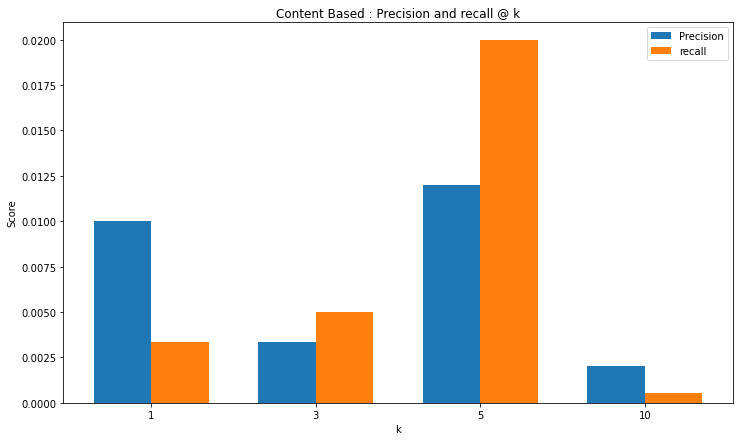

In [18]:
labels = [1, 3, 5, 10]

precision = [cb_perfos_dict[i][0] for i in labels]
recall = [cb_perfos_dict[i][1] for i in labels]

x = np.arange(len(labels))
width = 0.35

fig, ax= plt.subplots(figsize=(12, 7))
rects1 = ax.bar(x - width / 2, precision, width, label="Precision")
rects2 = ax.bar(x + width / 2, recall, width, label="recall")

ax.set_xlabel("k")
ax.set_ylabel("Score")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_title("Content Based : Precision and recall @ k")
ax.legend()

plt.show();

# - Collaborative filtering

## - Création / entraînement du modèle

In [19]:
class CollaborativeFilteringRecommender():
    """
    Recommend top n articles based on collaborative filtering.
    """
    
    def __init__(self, data, items, sample_size=None, save_lookup_dicts=False):
        """
        Input :
            - data (pd.Dataframe) : dataframe containing users / articles interactions
            - items (pd.Dataframe) : dataframe with all articles and their 
                                        their attached information
            - sample_size (int) : number of data lines to consider (to limit calculation time
            if needed)
            - save_lookup_dicts (bool) : if True, calculate lookup dictonaries and save them (long process).
            If False, use already saved dictionaries.
        """
        
        self.df = data.copy()
        
        if not sample_size:
            self.sample_size = len(self.df)
        else:
            self.sample_size = sample_size
            
        self.items = items
        self.save_lookup_dicts = save_lookup_dicts
        
        self.create_sparse_matrix()
        
    
    def inside_check(self):
        # Just used to return internal variables for checking
        return self.user_to_sparse_user
    
    def smooth_user_preference(self, x):
        """
        Smooth click counts :
        Input :
            - x (int) : number of clicks on an article for a single user
        Output :
            - (float) : smoothed number of clicks
        """
        
        return math.log(1+x, 2)
    
    def map_ids(self, row, mapper):
        """
        Convert indices between sparse and compressed matrices :
        Input :
            - row (int) : index to convert
            - mapper (dict of int) : dictionary used for conversion
        Output :
            - (int) : converted index
        """
        
        return mapper[row]
        
    def prepare_data(self):
        """
        Process input dataframe to include only relevant information :
        """
            
        self.df = self.df[["user_id", "click_article_id"]]
        self.df.rename(columns={"user_id": "user", "click_article_id": "item"},
                      inplace=True)
        self.df["click_counts"] = 1
        self.df = self.df.groupby(["user", "item"])["click_counts"] \
                    .sum().apply(self.smooth_user_preference).reset_index()
        
        self.df.sort_values(by="user", axis=0, inplace=True)
        self.df = self.df[:self.sample_size]

        self.df["user"] = self.df["user"].astype("category")
        self.df["item"] = self.df["item"].astype("category")
        
        self.df["user_code"] = self.df["user"].cat.codes
        self.df["item_code"] = self.df["item"].cat.codes
        
        self.item_lookup = self.items[["article_id", "category_id"]].drop_duplicates()
        self.item_lookup.rename(columns={"article_id": "item", "category_id": "category"}, inplace=True)
   
    
    def create_sparse_matrix(self):
        """
        Transform spare data into a scipy sparse matrix to save memory.
        Calculate lookup dictionaries for indices conversions.
        """
        
        def save(obj, file_name, folder="./resources"):
            """
            Save an object to disk in pickle format
            Input :
                - obj : object to save
                - file_name (str) : self explanatory
                - folder (str) : folder where to save file
            """
            
            file_name = file_name + ".pkl"
            file_name = os.path.join(folder, file_name)
            with open(file_name, "wb") as f:
                pickle.dump(obj, f)
        
        def load(file_name, folder="./resources"):
            """
            Load an object from disk in pickle format
            Input :
                - file_name (str) : name of the file to load
                - folder (str) : folder where the file is located
            Output :
                - loaded_file : object loaded
            """
            
            file_name = file_name + ".pkl"
            file_name = os.path.join(folder, file_name)
            with open(file_name, "rb") as f:
                loaded_file = pickle.load(f)
                
            return loaded_file
                
        
        self.prepare_data()
        
        item_to_idx = {}
        idx_to_item = {}
        for (idx, item) in enumerate(self.df["item_code"].unique().tolist()):
            item_to_idx[item] = idx
            idx_to_item[idx] = item

        user_to_idx = {}
        idx_to_user = {}
        for (idx, user) in enumerate(self.df["user_code"].unique().tolist()):
            user_to_idx[user] = idx
            idx_to_user[idx] = user
         
        I = self.df["user_code"].apply(self.map_ids, args=[user_to_idx]).values
        J = self.df["item_code"].apply(self.map_ids, args=[item_to_idx]).values
        V = np.ones(I.shape[0])
        
        clicks = sparse.coo_matrix((V, (I, J)), dtype=np.float64)
        self.clicks_sparse = clicks.tocsr()
        
        self.df["user_sparse_code"] = self.df["user_code"].map(user_to_idx)
        self.df["item_sparse_code"] = self.df["item_code"].map(item_to_idx)
        
        self.users_arr = np.sort(self.df["user_sparse_code"].unique()) # Get unique users
        self.items_arr = self.df["item_sparse_code"].unique() # Get our unique items that were read
        print("users_arr :\n", self.users_arr)
            
        if self.save_lookup_dicts:
            print("calcul des dictionnaires")
            save_dir = "./resources"
            self.item_to_sparse_item = {}
            self.sparse_item_to_item = {}
            for sparse_item in self.df["item_sparse_code"].unique().tolist():
                item = self.df[self.df["item_sparse_code"] == sparse_item]["item"].tolist()[0]
                self.item_to_sparse_item[item] = sparse_item
                self.sparse_item_to_item[sparse_item] = item

            self.user_to_sparse_user = {}
            self.sparse_user_to_user = {}
            for sparse_user in self.df["user_sparse_code"].unique().tolist():
                user = self.df[self.df["user_sparse_code"] == sparse_user]["user"].tolist()[0]
                self.user_to_sparse_user[user] = sparse_user
                self.sparse_user_to_user[sparse_user] = user
                
            save(self.item_to_sparse_item, "item_to_sparse_item")
            save(self.sparse_item_to_item, "sparse_item_to_item")
            save(self.user_to_sparse_user, "user_to_sparse_user")
            save(self.sparse_user_to_user, "sparse_user_to_user")
            
        else:
            print("chargement des dictionnaires")
            self.item_to_sparse_item = load("item_to_sparse_item")
            self.sparse_item_to_item = load("sparse_item_to_item")
            self.user_to_sparse_user = load("user_to_sparse_user")
            self.sparse_user_to_user = load("sparse_user_to_user")
            
        
    
    def make_train(self, pct_test = 0.2):
        """
        Create train and test set from the original user - item matrix. The test masks a percentage of the
        original data
        Input :
            - pct_test (float) : percentage of data masked
        Output :
            - loaded_file : object loaded
        """
       
        testing_set = self.clicks_sparse.copy() 
        testing_set[testing_set != 0] = 1 
        training_set = self.clicks_sparse.copy() 
        nonzero_inds = training_set.nonzero() 
        nonzero_pairs = list(zip(nonzero_inds[0], nonzero_inds[1])) 
        random.seed(0) 
        num_samples = int(np.ceil(pct_test*len(nonzero_pairs))) 
        samples = random.sample(nonzero_pairs, num_samples) 
        user_inds = [index[0] for index in samples] # Get the user row indices
        item_inds = [index[1] for index in samples] # Get the item column indices
        training_set[user_inds, item_inds] = 0 
        training_set.eliminate_zeros() # Get rid of zeros in sparse array storage after update to save space
        
        return training_set, testing_set, list(set(user_inds)) #
        
    def fit_model(self, alpha=15, factors=20, regularization=0.1, iterations=10,
                 pct_test=0.2):
        """
        Calculate users and items matrices that will be used for recommendations (dot product)
        Input :
            - alpha (int) : 
            - factors (int) : second dimension of users and items matrices
            - regularization (float) : regularization coefficient
            - iteration (int) : number od epochs for model training
            - pct_test (float) : percentage of data masked in training set
        Output :
            - user_vecs (np.array) : matrix containing users features
            - item_vecs (np.array) : matrix containing articles features
        """
        
        if pct_test != 0:
            print("Découpage en train / test avec pct_test = ", pct_test)
            self.train_set, self.test_set, self.items_users_altered = self.make_train(pct_test)
        else:
            print("pas de découpage en train / test")
            self.train_set = self.clicks_sparse
        
        self.user_vecs, self.item_vecs = \
            implicit.alternating_least_squares((self.train_set*alpha).astype('double'), 
                                                              factors=factors, 
                                                              regularization=regularization, 
                                                              iterations=iterations)
        
        return self.user_vecs, self.item_vecs
    
    
    def rec_items(self, user_id, num_items = 10):
        """
        Calculate and return the recommnded items
        Input :
            - user_id (int) : user for whom recmmendations are calculated
            - num_items (int) : number of recommnded items
        Output :
            - codes (list of int) : recommended items
            - (pd.DataFrame) : recommended items and their attached category (for easier analysis)
        """
        
        user_id = self.user_to_sparse_user[user_id]
        user_ind = np.where(self.users_arr == user_id)[0][0] 
        pref_vec = self.train_set[user_ind,:].toarray() 
        pref_vec = pref_vec.reshape(-1) + 1 
        pref_vec[pref_vec > 1] = 0 # Make everything already purchased zero
        rec_vector = self.user_vecs[user_ind,:].dot(self.item_vecs.T) 
        
        # Scale this recommendation vector between 0 and 1
        min_max = MinMaxScaler()
        rec_vector_scaled = min_max.fit_transform(rec_vector.reshape(-1,1))[:,0] 
        recommend_vector = pref_vec*rec_vector_scaled 
        # Items already purchased have their recommendation multiplied by zero
        
        product_idx = np.argsort(recommend_vector)[::-1][:num_items] 
        rec_list = [] 
        for index in product_idx:
            code = self.items_arr[index]
            code = self.sparse_item_to_item[code]
            rec_list.append([code, 
                             self.item_lookup["category"].loc[self.item_lookup["item"] == code].iloc[0]]) 
        codes = [item[0] for item in rec_list]

        descriptions = [item[1] for item in rec_list]
        final_frame = pd.DataFrame({'item': codes, 'category': descriptions}) 
        
        return codes, final_frame[['item', 'category']] 
    
    
    def auc_score(self, predictions, test):
        """
        Calculate the area under the curve
        Input :
            - predictions (list of int) : list of recommended items
            - test (list of int) : list of actualy read articles items
        Output :
            - (float) : calculated auc
        """

        fpr, tpr, thresholds = metrics.roc_curve(test, predictions)
        
        return metrics.auc(fpr, tpr)
    
    
    def evaluate_perfo(self, k):
        """
        Calculate model performance
        Input :
            - k (int) : number recommended items
        Output :
            - cf_auc (float) : area under the curve for this recommendation algorithm
            - pop_auc (float) : area under the curve using most popular recommendations
                                (for comparison purpose)
            - precision (float)
            - recall (float)
        """

        predictions = [sparse.csr_matrix(self.user_vecs), sparse.csr_matrix(self.item_vecs.T)]
        store_auc = []         
        precisions = []
        popularity_auc = [] 
        recalls = []
        
        pop_items = np.array(self.test_set.sum(axis = 0)).reshape(-1) # Get sum of item iteractions
                                                                    # to find most popular
        item_vecs = predictions[1]
        for user in self.items_users_altered: 
            training_row = self.train_set[user,:].toarray().reshape(-1) 
            zero_inds = np.where(training_row == 0) # Find where the interaction had not yet occurred
            
            # Get the predicted values based on our user/item vectors
            user_vec = predictions[0][user,:]
            pred = user_vec.dot(item_vecs).toarray()[0,zero_inds].reshape(-1)

            actual = self.test_set[user,:].toarray()[0,zero_inds].reshape(-1) 

            pop = pop_items[zero_inds]
            store_auc.append(self.auc_score(pred, actual)) 
            popularity_auc.append(self.auc_score(pop, actual)) 


            read_items = np.where(actual == 1)[0]
            topk = np.flip(np.argsort(pred))[:k]
            hits = float(len(set(topk) & set(read_items)))
            precision = hits / k
            recall =  hits / float(len(read_items))
            precisions.append(precision)
            recalls.append(recall)

        cf_auc = np.mean(store_auc)
        pop_auc = np.mean(popularity_auc)
        precision = np.mean(precisions)
        recall = np.mean(recalls)
        try :
            f1 = (2 * precision * recall) / (precision + recall)
        except ZeroDivisionError :
            f1 = 0
        
        return [float("%.3f"%cf_auc),
                float("%.3f"%pop_auc),
                float("%.3f"%precision),
                float("%.3f"%recall),
                float("%.3f"%f1)]

    def get_read_items(self, user_id):
        """
        List articles read by a user
        Input :
            - user_id (int) : user
        Output :
            - (pd.DataFrame) : articles read by the user
        """
        
        user_id = self.user_to_sparse_user[user_id]
        print("user_id :", user_id)
        print("train_set :", self.train_set)
        user_ind = np.where(self.users_arr == user_id)[0][0] 
        print("user_ind :", user_ind)
        purchased_ind = self.train_set[user_ind,:].nonzero()[1]
        print("purchased ind :", purchased_ind)
        item_codes = [self.sparse_item_to_item[x] for x in purchased_ind] 
        print("item_codes :", item_codes)

        return self.item_lookup.loc[self.item_lookup["item"].isin(item_codes)]


In [20]:
%%time
cf_model = CollaborativeFilteringRecommender(df, items_df, sample_size=100000, save_lookup_dicts=True)

users_arr :
 [   0    1    2 ... 4235 4236 4237]
calcul des dictionnaires
CPU times: user 16.2 s, sys: 3.54 s, total: 19.7 s
Wall time: 12.4 s


In [21]:
user_vecs, item_vecs = cf_model.fit_model(iterations=10, pct_test=0.2)

This method is deprecated. Please use the AlternatingLeastSquares class instead


Découpage en train / test avec pct_test =  0.2


In [22]:
print("user_vecs.shape :", user_vecs.shape)
print("item_vecs.shape :", item_vecs.shape)

user_vecs.shape : (4238, 20)
item_vecs.shape : (8648, 20)


## - Exemple de prédictions

In [23]:
rec_items_list, rec_items_df = cf_model.rec_items(user_id=3, num_items=5)
print(rec_items_list)
rec_items_df

[235840, 237620, 183176, 235132, 111043]


,item,category
0,235840,375
1,237620,375
2,183176,301
3,235132,375
4,111043,231


## - Evaluation des performances

In [24]:
cf_perfos = cf_model.evaluate_perfo(k=10)
print(cf_perfos)

[0.855, 0.917, 0.06, 0.166, 0.088]


In [25]:
%%time
k_list = [1, 3, 5, 10]
cf_perfos_dict = dict()
for i in k_list:
    cf_perfos_dict[i] = cf_model.evaluate_perfo(k=i)

CPU times: user 43.9 s, sys: 0 ns, total: 43.9 s
Wall time: 43.9 s


In [26]:
cf_perfos_dict

{1: [0.855, 0.917, 0.095, 0.029, 0.045],
 3: [0.855, 0.917, 0.082, 0.079, 0.08],
 5: [0.855, 0.917, 0.074, 0.112, 0.089],
 10: [0.855, 0.917, 0.06, 0.166, 0.088]}

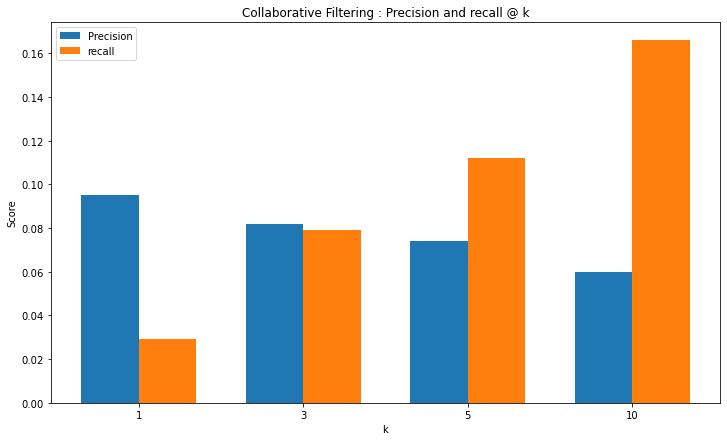

In [27]:
labels = [1, 3, 5, 10]

precision = [cf_perfos_dict[i][2] for i in labels]
recall = [cf_perfos_dict[i][3] for i in labels]

x = np.arange(len(labels))
width = 0.35

fig, ax= plt.subplots(figsize=(12, 7))
rects1 = ax.bar(x - width / 2, precision, width, label="Precision")
rects2 = ax.bar(x + width / 2, recall, width, label="recall")

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_xlabel("k")
ax.set_ylabel("Score")
ax.set_title("Collaborative Filtering : Precision and recall @ k")
ax.legend()

plt.show();

# - Comparaison des performances

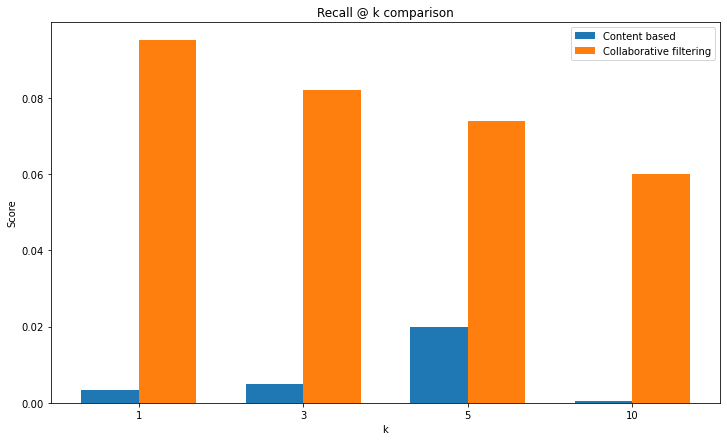

In [28]:
cb_recall = [cb_perfos_dict[i][1] for i in labels]
cf_recall = [cf_perfos_dict[i][2] for i in labels]

x = np.arange(len(labels))
width = 0.35

fig, ax= plt.subplots(figsize=(12, 7))
rects1 = ax.bar(x - width / 2, cb_recall, width, label="Content based")
rects2 = ax.bar(x + width / 2, cf_recall, width, label="Collaborative filtering")

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_xlabel("k")
ax.set_ylabel("Score")
ax.set_title("Recall @ k comparison")
ax.legend()

plt.show();

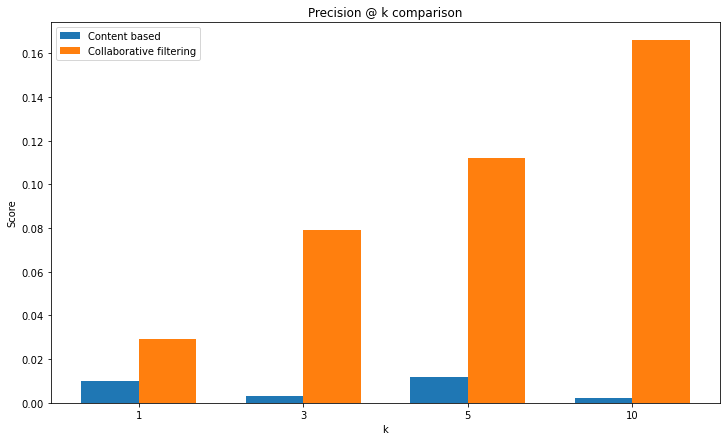

In [29]:
cb_precision = [cb_perfos_dict[i][0] for i in labels]
cf_precision = [cf_perfos_dict[i][3] for i in labels]

x = np.arange(len(labels))
width = 0.35

fig, ax= plt.subplots(figsize=(12, 7))
rects1 = ax.bar(x - width / 2, cb_precision, width, label="Content based")
rects2 = ax.bar(x + width / 2, cf_precision, width, label="Collaborative filtering")

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_xlabel("k")
ax.set_ylabel("Score")
ax.set_title("Precision @ k comparison")
ax.legend()

plt.show();

In [40]:
cf_perfos

{1: [0.859, 0.917, 0.096, 0.034, 0.05],
 3: [0.859, 0.917, 0.081, 0.078, 0.08],
 5: [0.859, 0.917, 0.074, 0.116, 0.09],
 10: [0.859, 0.917, 0.061, 0.172, 0.09]}